In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import gpflow # This is the only package that might be difficult to download
clear_output()

### Load in the daily aggregates

In [8]:
data = pd.read_csv('daily_aggregate_data.csv')
data['Day'] = pd.to_datetime(data.Date)
data.drop('Date', inplace=True, axis=1)
data.head()

,mean_power,mean_radiation,mean_temp,mean_humid,mean_cloud,mean_panel,Day
0,123.982944,0.657340,33.444444,49.333333,3.222222,0.078967,2020-03-01
1,45.944690,0.664005,49.000000,66.555556,7.666667,0.029263,2020-03-02
2,28.223212,0.670670,48.000000,85.555556,8.000000,0.017976,2020-03-03
3,114.439394,0.677332,41.333333,60.000000,6.444444,0.072888,2020-03-04
4,158.847140,0.683989,39.111111,51.888889,4.000000,0.101173,2020-03-05


### Cross validation function for any of the predictors

In [9]:
def kfold(folds, predictors):
    kfold = 5
    shuffled_dates = np.random.choice(data.Day.dt.date, data.shape[0], replace=False)
    step = int(len(shuffled_dates)/kfold)
    np.random.seed(1)
    rmse_list = []
    for i in range(kfold):
        train = data.loc[~data.Day.dt.date.isin(shuffled_dates[i*step:(i+1)*step])].copy()
        test = data.loc[data.Day.dt.date.isin(shuffled_dates[i*step:(i+1)*step])].copy()
        
        for p in predictors:
            train_mean, train_sd = (train[f'{p}'].mean(), train[f'{p}'].std())
            train[f'{p}_s'] = (train[f'{p}'] - train_mean) / train_sd
            test[f'{p}_s'] = (test[f'{p}'] - train_mean) / train_sd
        mean_panel, sd_panel = (train['mean_panel'].mean(), train['mean_panel'].std())
        train['mean_panel_s'] = (train['mean_panel'] - mean_panel) / sd_panel
        test['mean_panel_s'] = (test['mean_panel'] - mean_panel) / sd_panel
        

        # Model definition
        k = gpflow.kernels.RBF(len(predictors), lengthscales=2.5)
        X = train[[f'{p}_s' for p in predictors]].values
        m = gpflow.models.GPR(X = X, Y = train.mean_panel_s.values.reshape(-1,1), kern=k, mean_function=None)
        clear_output()

        mean, _ = m.predict_f(test[[f'{p}_s' for p in predictors]].values)
        pred_panel_power = (mean * sd_panel + mean_panel) * 1570.061376
        rmse = np.sqrt(np.mean(((test['mean_panel'].values.reshape(-1,1) * 1570.061376) - pred_panel_power)**2))
        rmse_list.append(rmse)

    return rmse_list

In [15]:
t_rmse = np.mean(kfold(5, ["mean_temp"]))
cc_rmse = np.mean(kfold(5, ["mean_cloud"]))
sr_rmse = np.mean(kfold(5, ["mean_radiation"]))
ccsr_rmse = np.mean(kfold(5, ["mean_cloud", "mean_radiation"]))
tccsr_rmse = np.mean(kfold(5, ["mean_cloud", "mean_radiation", "mean_temp"]))

print(f'5-Fold RMSE for [T]: {t_rmse}')
print(f'5-Fold RMSE for [CC]: {cc_rmse}')
print(f'5-Fold RMSE for [SR]: {sr_rmse}')
print(f'5-Fold RMSE for [CC, SR]: {ccsr_rmse}')
print(f'5-Fold RMSE for [T, CC, SR]: {tccsr_rmse}')

5-Fold RMSE for [T]: 48.749965437525454
5-Fold RMSE for [CC]: 34.24113716247016
5-Fold RMSE for [SR]: 46.417900256977425
5-Fold RMSE for [CC, SR]: 24.072273565082575
5-Fold RMSE for [T, CC, SR]: 23.42672066337905


### Sensitivity Analysis

#### Standardize the data

In [16]:
data_s = data.copy()
data_s['mean_panel'] = data_s.mean_panel * 1570.061376 # Transform back to KW
data_s['mean_temp_s'] = (data_s.mean_temp - data_s.mean_temp.mean()) / data_s.mean_temp.std()
data_s['mean_cloud_s'] = (data_s.mean_cloud - data_s.mean_cloud.mean()) / data_s.mean_cloud.std()
data_s['mean_radiation_s'] = (data_s.mean_radiation - data_s.mean_radiation.mean()) / data_s.mean_radiation.std()
data_s['mean_panel_s'] = (data_s.mean_panel - data_s.mean_panel.mean()) / data_s.mean_panel.std()

k = gpflow.kernels.RBF(3, lengthscales=2.5)
X = data_s[['mean_cloud_s', 'mean_temp_s', 'mean_radiation_s']].values
m = gpflow.models.GPR(X = X, Y = data_s.mean_panel_s.values.reshape(-1,1), kern=k, mean_function=None)
clear_output()

In [17]:
def sens_analysis(sens_pred, comp_preds, n_sens_lvls, legend_labels, x_label, y_label):
    f1 = np.zeros((data.shape[0], len(sens_pred + comp_preds)))
    f2 = np.zeros((data.shape[0], len(sens_pred + comp_preds)))
    f1[:,0] = data_s[sens_pred].sort_values(sens_pred[0]).values.reshape(-1)
    f2[:,0] = data_s[sens_pred].sort_values(sens_pred[0]).values.reshape(-1)
    f1_range = np.linspace(np.min(data_s[[comp_preds[0]]]), np.max(data_s[[comp_preds[0]]]), n_sens_lvls)
    f2_range = np.linspace(np.min(data_s[[comp_preds[1]]]), np.max(data_s[[comp_preds[1]]]), n_sens_lvls)
    
    k = gpflow.kernels.RBF(3, lengthscales=2.5)
    X = data_s[sens_pred+comp_preds].values
    m = gpflow.models.GPR(X = X, Y = data_s.mean_panel_s.values.reshape(-1,1), kern=k, mean_function=None)
    clear_output()
    fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(20,10))
    ax_1.scatter(data_s[sens_pred], data_s.mean_panel_s, c='darkblue')
    ax_2.scatter(data_s[sens_pred], data_s.mean_panel_s, c='darkblue')
    for i,j in zip(f1_range, f2_range):
        # Other columns in f frames do not need to be specified since they are mnean zero
        f1[:,1] = i
        f2[:,2] = j
        mean_1, _ = m.predict_f(f1)
        mean_2, _ = m.predict_f(f2)
        
        ax_1.plot(data_s[sens_pred].sort_values(sens_pred[0]), mean_1, lw=3, 
                  label=f'{legend_labels[0]}: {np.round((i * data[[comp_preds[0][:-2]]].std() + data[[comp_preds[0][:-2]]].mean()).values, 2)[0]}')
        ax_1.legend(fontsize=14)
        ax_1.set_xlabel(x_label, fontsize=14, fontweight='bold')
        ax_1.set_ylabel(y_label, fontsize=14, fontweight='bold')
        
        ax_2.plot(data_s[sens_pred].sort_values(sens_pred[0]), mean_2, lw=3,
                 label=f'{legend_labels[1]}: {np.round((i * data[[comp_preds[1][:-2]]].std() + data[[comp_preds[1][:-2]]].mean()).values, 2)[0]}')
        ax_2.legend(fontsize=14)
        ax_2.set_xlabel(x_label, fontsize=14, fontweight='bold')
        ax_2.set_ylabel(y_label, fontsize=14, fontweight='bold')
    plt.show()

#### Cloud Cover sensitivity

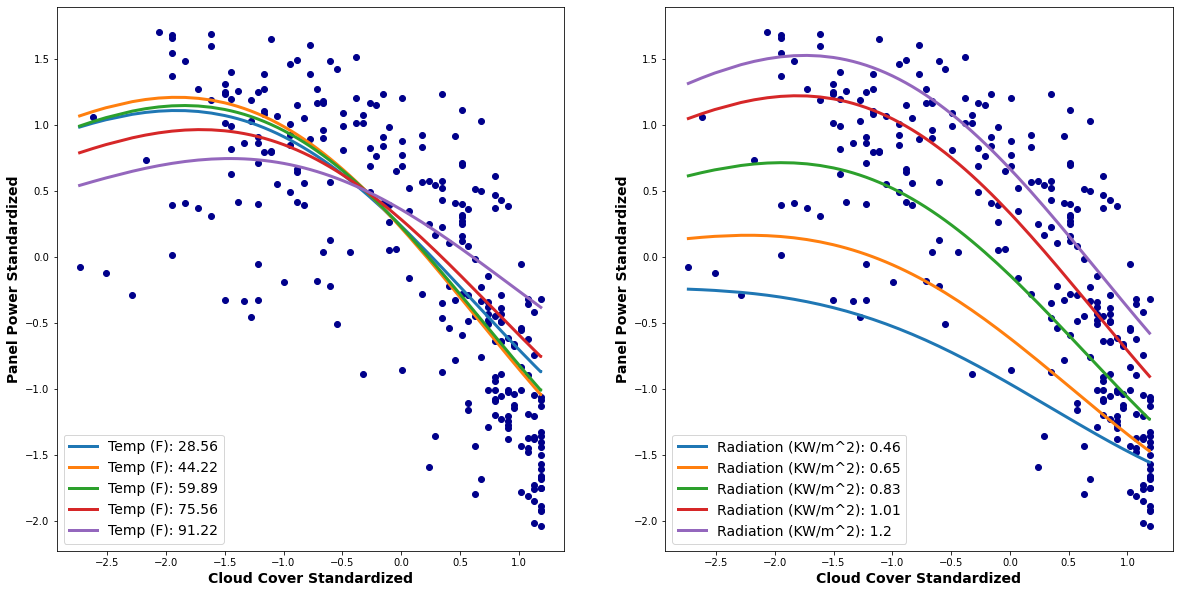

In [19]:
sens_analysis(['mean_cloud_s'], ['mean_temp_s', 'mean_radiation_s'], 5, ['Temp (F)', 'Radiation (KW/m^2)'], 'Cloud Cover Standardized', 'Panel Power Standardized')

#### Temperature Sensitivity

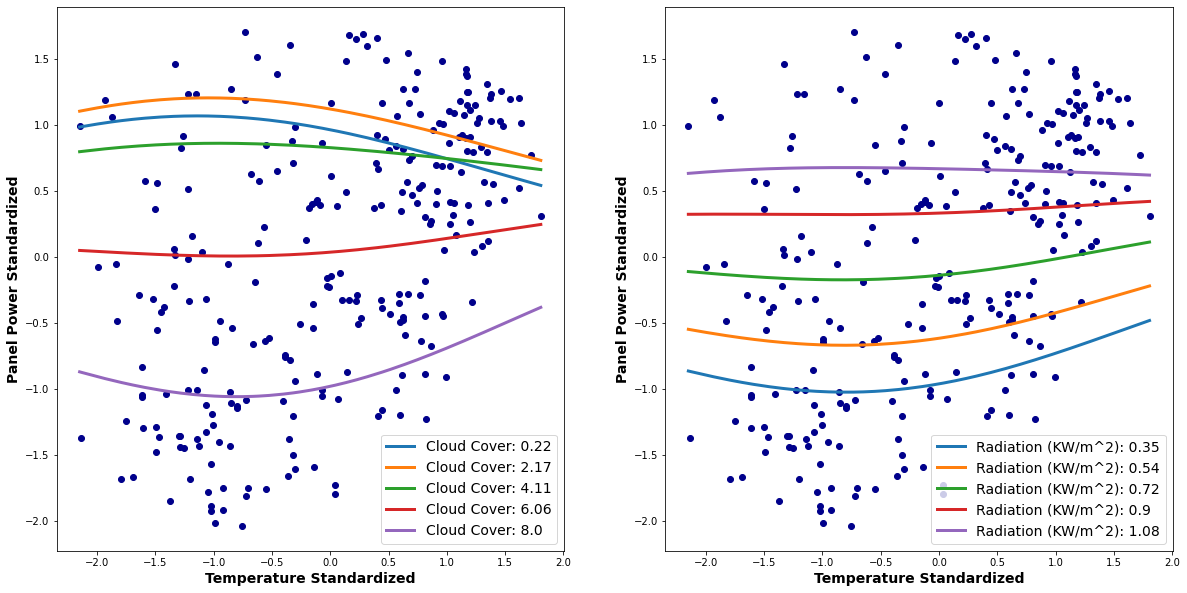

In [20]:
sens_analysis(['mean_temp_s'], ['mean_cloud_s', 'mean_radiation_s'], 5, ['Cloud Cover', 'Radiation (KW/m^2)'], 'Temperature Standardized', 'Panel Power Standardized')

#### Solar Radiation Sensitivity

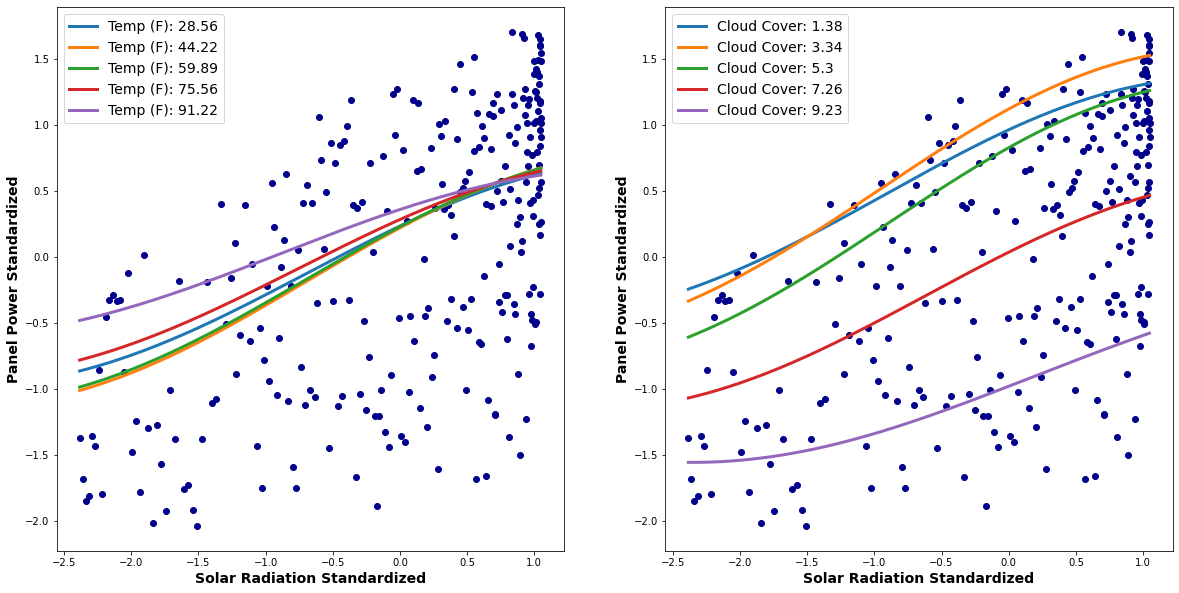

In [21]:
sens_analysis(['mean_radiation_s'], ['mean_temp_s', 'mean_cloud_s'], 5, ['Temp (F)', 'Cloud Cover'], 'Solar Radiation Standardized', 'Panel Power Standardized')